In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Datasets/
import pandas as pd
df = pd.read_csv('processed.cleveland.data')

/content/drive/MyDrive/Datasets


In [ ]:
#These are the packages the code requires for you to install
!pip install keras-tuner
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install matplotlib
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/s

In [ ]:
#1: Age in Years
#2: Sex (0 = F, 1 = M) 
#3: Chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic) 
#4: Resting blood pressure at admission (mmHg),
#5: Serum cholesterol (mmHg) 
#6: Fasting blood sugar > 120 mg/DL 1 = T, 0 = F
#7: Resting electrocardiographic results: 0 = normal, 1 = ST-T wave abnormality, 2 = probable/definite left ventricular hypertrophy
#8: Maximum heart rate achieved
#9: Exercise induced angina (1 = yes, 0 = no)
#10: ST depression induced by exercise relative to rest
#11: Slope of peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
#12: Number of major vessels (0-3) colored by fluoroscopy 
#13: Thalassemia (3 = normal, 6 = fixed defect, 7 = reversable defect)
#14: Diagnosis of Heart Disease (Angiographic Disease- 0: <50% diameter narrowing, 1: > 50% diameter narrowing)
df.columns = ['Age (Years)', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure (mmHg)', 'Serum Cholesterol (mmHg)', 'Fasting Blood Sugar > 120 mg/dL', 'Resting Electrocardiographic Results', 'Maximum Heart Rate Achieved', 'Exercise-Induced Angina', 'ST Depression Induced by Exercise Relative to Rest', 'Slope of the Peak Exercise ST Segment','Number of Major Vessels Colored by Fluoroscopy', 'Thalassemia', 'Diagnosis of Heart Disease']


With missing values:  (303, 14)
Without missing values:  (297, 14)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (297) is greater than the total number of samples (237). n_quantiles is set to n_samples.
  warnings.warn(


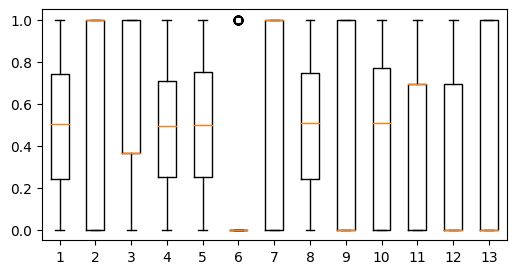

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('processed.cleveland.data', header=None)
df.columns = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG',
              'MaxHR', 'ExerciseAngina', 'Oldpeak', 'STslope', 'MajorVessels', 'Thal', 'Target']

# Replace "?" with NaN
df.replace('?', np.nan, inplace=True)

# Convert data to float
df = df.astype(float)

# Drop rows with NaN values
print("With missing values: ", df.shape)
df.dropna(inplace=True)
print("Without missing values: ", df.shape)

# Select the features and target
X = df.iloc[:, :13].values
y = df.iloc[:, 13].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = QuantileTransformer(n_quantiles=df.shape[0], output_distribution="uniform", random_state=1111)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

fig = plt.figure(figsize =(6, 3))
plt.boxplot(X_train)
plt.show()

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
import json

# Define the input shape and the number of neurons in the latent space (d)
input_shape = X_train.shape[1:]
d = 5

# Define the encoder model
def build_encoder(hp):
    inputs = Input(shape=input_shape)
    x = Dense(units=hp.Int('encoder_units_1', min_value=32, max_value=256, step=32), activation='relu')(inputs)
    x = Dense(units=hp.Int('encoder_units_2', min_value=16, max_value=128, step=16), activation='relu')(x)
    x = Dense(units=hp.Int('encoder_units_3', min_value=8, max_value=64, step=8), activation='relu')(x)
    latent_space = Dense(units=d, activation='relu')(x)
    encoder = Model(inputs, latent_space)
    return encoder

# Define the decoder model
def build_decoder(hp):
    decoder_inputs = Input(shape=(d,))
    x = Dense(units=hp.Int('decoder_units_1', min_value=16, max_value=128, step=16), activation='relu')(decoder_inputs)
    x = Dense(units=hp.Int('decoder_units_2', min_value=32, max_value=256, step=32), activation='relu')(x)
    x = Dense(units=hp.Int('decoder_units_3', min_value=64, max_value=512, step=64), activation='relu')(x)
    outputs = Dense(units=input_shape[0], activation='linear')(x)
    decoder = Model(decoder_inputs, outputs)
    return decoder


# Define the autoencoder model by combining the encoder and decoder models
def build_autoencoder(hp):
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    batch_size = hp.Int('batch_size', min_value=16, max_value=128, step=16)
    autoencoder_input = Input(shape=input_shape)
    encoder_output = build_encoder(hp)(autoencoder_input)
    decoder_output = build_decoder(hp)(encoder_output)
    autoencoder = Model(autoencoder_input, decoder_output)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return autoencoder

# Define the tuner
tuner = RandomSearch(
    build_autoencoder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='ExtraHiddenLayer',
    overwrite=True, 
    seed=42)

# Perform hyperparameter search
tuner.search(X_train, X_train, epochs=1000, batch_size=32, validation_data=(X_test, X_test))

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = build_autoencoder(best_hps)

# Add EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Train the final model
history = final_model.fit(X_train, X_train,
                          epochs=1000,
                          batch_size=32,
                          verbose=1,
                          validation_data=(X_test, X_test),
                          callbacks=[es])

# Save the model as a .h5 file
model_filename = "ExtraHiddenLayer.h5"
final_model.save(model_filename)

# Store the hyperparameters and evaluation metrics in a dictionary
hyperparameters_dict = {"learning_rate": best_hps.get('learning_rate'),
                        "batch_size": best_hps.get('batch_size'),
                        "accuracy": history.history['val_loss'][-1]}

# Save the dictionary as a JSON file
filename = "ExtraHiddenLayer.json"
with open(filename, "w") as f:
    json.dump(hyperparameters_dict, f)

Trial 10 Complete [00h 05m 46s]
val_loss: 0.05463113387425741

Best val_loss So Far: 0.04719998314976692
Total elapsed time: 01h 01m 47s
Epoch 1/1000
8/8 [==============================] - 2s 45ms/step - loss: 0.3410 - val_loss: 0.2217
Epoch 2/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.1837 - val_loss: 0.1686
Epoch 3/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1426 - val_loss: 0.1315
Epoch 4/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1397 - val_loss: 0.1246
Epoch 5/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1320 - val_loss: 0.1233
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.1276 - val_loss: 0.1227
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.1246 - val_loss: 0.1184
Epoch 8/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.1194 - val_loss: 0.1125
Epoch 9/1000
8/8 [==============================] - 0s 11ms/step - loss: 

In [8]:
test_loss = final_model.evaluate(X_test, X_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.0458


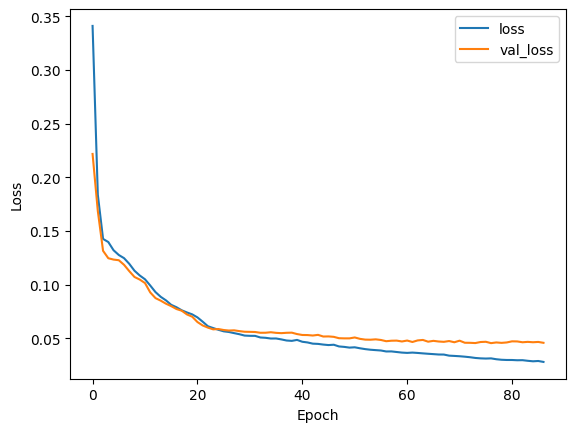

In [9]:
import matplotlib.pyplot as plt

history_dict = history.history
for k,v in history_dict.items():
  plt.plot(v, label=k)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

In [10]:
# Predict the reconstructed output for each input
reconstructed_X = final_model.predict(X_test)

# Calculate the mean squared error between the original input and its reconstructed output for each feature separately
fmse = np.mean(np.square(reconstructed_X - X_test), axis=0)

2/2 [==============================] - 0s 8ms/step


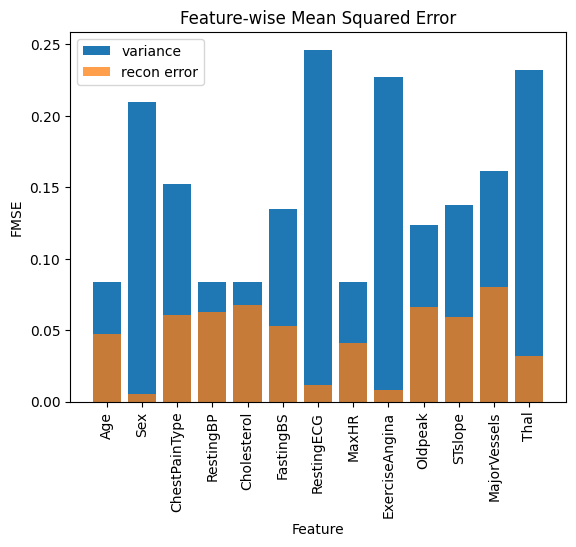

In [11]:
# Create a list of feature names
feature_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG',
              'MaxHR', 'ExerciseAngina', 'Oldpeak', 'STslope', 'MajorVessels', 'Thal']

# Set the x-axis tick labels
plt.xticks(range(len(feature_names)), feature_names, rotation=90)

# Create a bar plot of the FMSE values
variance = np.var(X_train, axis=0).flatten()
plt.bar(feature_names, variance, label="variance")
plt.bar(feature_names, fmse, label="recon error", alpha=0.75)
plt.title('Feature-wise Mean Squared Error')
plt.xlabel('Feature')
plt.ylabel('FMSE')
plt.legend()
plt.show()

In [ ]:
# Print the shape of X_test and the length of fmse
print("Shape of X_test:", X_test.shape)
print("Length of fmse:", len(fmse))


Shape of X_test: (60, 13)
Length of fmse: 13


In [12]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model to the training data
reg = LinearRegression().fit(X_train, y_train)

# Get the coefficients (importances) of each feature
importances = reg.coef_

# Sort the features by importance (descending order)
sorted_idx = np.argsort(importances)[::-1]

# Print the feature importances
for i in sorted_idx:
    print(f"{feature_names[i]}: {importances[i]:.3f}")

MajorVessels: 1.009
ChestPainType: 0.682
RestingBP: 0.552
Thal: 0.451
STslope: 0.383
Sex: 0.273
Oldpeak: 0.211
RestingECG: 0.210
Cholesterol: 0.181
ExerciseAngina: 0.068
FastingBS: -0.044
Age: -0.219
MaxHR: -0.564


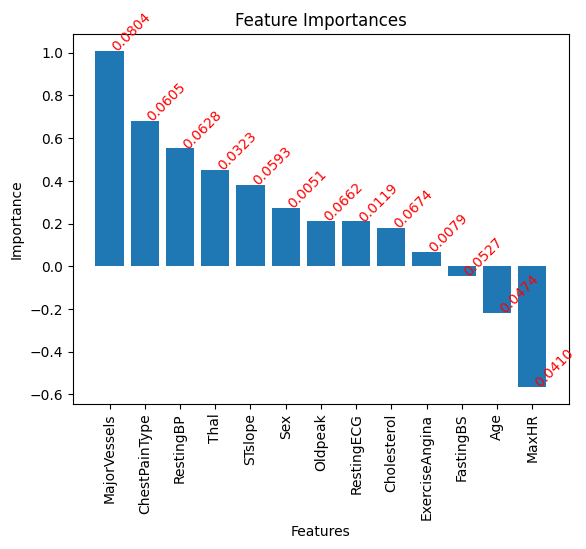

In [13]:
# Sort the feature importances by importance (descending order)
sorted_idx = np.argsort(importances)[::-1]

# Create a bar plot of feature importances
plt.bar(range(X_train.shape[1]), importances[sorted_idx], align='center')

# Add labels for each feature
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[sorted_idx], rotation=90)

# Add labels for each FMSE value
for i, v in enumerate(["{:.4f}".format(val) for val in fmse[sorted_idx]]):
  plt.text(i, importances[sorted_idx][i], str(v), color='red', fontweight='regular', rotation=45)

# Set plot title and axis labels
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")

# Show the plot
plt.show()

# New Section